In [1]:
import numpy as np
import pandas as pd
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )
api_key = '07c743da178e65cad9e43897e89fc202'
import ast
import statistics
import matplotlib.pyplot as plt

In [175]:
fixDates = pd.read_csv('dsfinal/testDates.csv', sep=',', usecols=['release_date'], squeeze=True)

0       7/14/2007
1       5/19/1958
2       5/23/1997
3        9/4/2010
4       2/11/2005
          ...    
4392     8/3/2001
4393    8/20/2004
4394    12/8/1982
4395     2/4/2015
4396    9/20/1962
Name: release_date, Length: 4397, dtype: object

In [177]:
train = pd.read_csv('dsfinal/train.csv')
test = pd.read_csv('dsfinal/test.csv')
test['release_date'] = fixDates

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/2007,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/1958,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/1997,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/2010,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/2005,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,NaN,42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,...,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/20/2004,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de..."
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0364751,en,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",12/8/1982,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The call of the wild, the thrill of adventure....",Without a Paddle,"[{'id': 4959, 'name': 'death of a friend'}, {'...","[{'cast_id': 40, 'character': 'Da

In [321]:
#get revenue for test data so the dict for crew/actor movies can be created
def getRev(row):
    response = requests.get('https://api.themoviedb.org/3/find/'+ row.imdb_id + '?api_key=' + api_key +'&language=en-US&external_source=imdb_id')
    if 'movie_results' in response.json().keys():
        if len(response.json()['movie_results']) >= 1:
            tmdbid = response.json()['movie_results'][0]['id']
        else:
            return 0
    else:
        return 0
    response = requests.get('https://api.themoviedb.org/3/movie/' + str(tmdbid) + '?api_key=' +  api_key + '&language=en-US')
    if 'revenue' in response.json().keys():
        return response.json()['revenue']
    else: 
        return 0

In [ ]:
#commented out below line to make sure it doesnt get accidentally run (long run time)
#revenues = test.apply(lambda row: getRev(row), axis = 1)
test['revenue'] = revenues

frames = [train, test]
combined = pd.concat(frames, sort = False)

In [179]:
trainpre = train
trainpre = trainpre.drop(["homepage", "imdb_id", "popularity", "overview", "tagline", "status", "poster_path"], axis=1)
combined = combined.drop(["homepage", "imdb_id", "popularity", "overview", "tagline", "status", "poster_path"], axis=1)

In [180]:
trainpre['belongs_to_collection'] = trainpre['belongs_to_collection'].fillna(0)
trainpre.loc[trainpre.belongs_to_collection != '', 'has_collection'] = '1'
trainpre.loc[trainpre.belongs_to_collection == 0, 'has_collection'] = '0'
trainpre['collection'] = trainpre.apply(lambda row: ast.literal_eval(row.belongs_to_collection) if type(row.belongs_to_collection) == str else 0, axis = 1)
trainpre['collection_name'] = trainpre.apply(lambda row: row.collection[0]['name'] if type(row.collection) == list else 0, axis = 1)
trainpre['cast'] = trainpre.apply(lambda row: ast.literal_eval(row.cast) if type(row.cast) == str else 0, axis = 1)
trainpre['crew'] = trainpre.apply(lambda row: ast.literal_eval(row.crew) if type(row.crew) == str else 0, axis = 1)
trainpre['production_companies'] = trainpre.apply(lambda row: ast.literal_eval(row.production_companies) if type(row.production_companies) == str else 0, axis = 1)



In [181]:
combined['belongs_to_collection'] = combined['belongs_to_collection'].fillna(0)
combined.loc[combined.belongs_to_collection != '', 'has_collection'] = '1'
combined.loc[combined.belongs_to_collection == 0, 'has_collection'] = '0'
combined['collection'] = combined.apply(lambda row: ast.literal_eval(row.belongs_to_collection) if type(row.belongs_to_collection) == str else 0, axis = 1)
combined['collection_name'] = combined.apply(lambda row: row.collection[0]['name'] if type(row.collection) == list else 0, axis = 1)
combined['cast'] = combined.apply(lambda row: ast.literal_eval(row.cast) if type(row.cast) == str else 0, axis = 1)
combined['crew'] = combined.apply(lambda row: ast.literal_eval(row.crew) if type(row.crew) == str else 0, axis = 1)
combined['production_companies'] = combined.apply(lambda row: ast.literal_eval(row.production_companies) if type(row.production_companies) == str else 0, axis = 1)
combined

,id,belongs_to_collection,budget,genres,original_language,original_title,production_companies,production_countries,release_date,runtime,spoken_languages,title,Keywords,cast,crew,revenue,has_collection,collection,collection_name
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/2015,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",Hot Tub Time Machine Collection
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/2004,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1,"[{'id': 107674, 'name': 'The Princess Diaries ...",The Princess Diaries Collection
2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",en,Whiplash,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/2014,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,0
3,4,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Kahaani,0,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/2012,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0,0
4,5,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,마린보이,0,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/2009,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,0,42000000,"[{'id': 53, 'name': 'Thriller'}]",en,Original Sin,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/20/2004,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de...",35402320,0,0,0
4394,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,Without a Paddle,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/8/1982,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Without a Paddle,"[{'id': 4959, 'name': 'death of a friend'}, {'...","[{'cast_id': 40, 'character': 'Dan Mott', 'cre...","[{'credit_id': '52fe43b29251416c7501a909', 'de...",69631118,1,"[{'id': 146534, 'name': 'Without a Paddle Coll...",Without a Paddle Collection
4395,7396,0,16000000,"[{'id': 18, 'name': 'Drama'}]",en,The Verdict,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/4/2015,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Verdict,"[{'id': 1680, 'name': 'boston'}, {'id': 6148, ...","[{'cast_id': 1, 'character': 'Frank Galvin', '...","[{'credit_id': '52fe448bc3a368484e028c55', 'de...",53977250,0,0,0
4396,7397,0,2000000,"[{'id': 27, 'nam

In [352]:
def actorReturn(row):
    if type(row.cast) == list:
        if len(row.cast) >= 2:
            actors = {
                "actor1": row.cast[0]['name'],
                "actor2": row.cast[1]['name']
            }
            return actors
        elif len(row.cast) == 1:
            actors = {
                "actor1": row.cast[0]['name'],
            }
            return actors
        else:
                    return {}
    else:
        return {}
    
def returnCrew(crew):
    crewDict = {
        'Director': None,
        'Producer': None
    }
    direc = 0
    prod = 0
    for x in crew:
        #print(crewDict)
        if x['job'] == 'Director':
            crewDict['Director'] = x['name']
            direc = 1
        elif x['job'] == 'Producer':
            crewDict['Producer'] = x['name']
            prod = 1
        if direc > 0 and prod > 0:
            return crewDict
    return crewDict

In [353]:
trainpre['rel_actors'] = trainpre.apply(lambda row: actorReturn(row), axis =1) 
trainpre['rel_crew'] = trainpre.apply(lambda row: returnCrew(row.crew) if type(row.crew) == list else {},  axis =1)
combined['rel_actors'] = combined.apply(lambda row: actorReturn(row), axis =1) 
combined['rel_crew'] = combined.apply(lambda row: returnCrew(row.crew) if type(row.crew) == list else {},  axis =1)
test['rel_actors'] = test.apply(lambda row: actorReturn(row), axis =1) 
test['rel_crew'] = test.apply(lambda row: returnCrew(row.crew) if type(row.crew) == list else {},  axis =1)

In [ ]:
workerPerformance = pd.DataFrame(columns=['revenue', 'Director', 'date', 'Producer', 'actor1','actor2'])
workerPerformance['revenue'] = combined.apply(lambda row: row.revenue if 'Director' in row.rel_crew.keys() else  None, axis =1) 
workerPerformance['Director'] = combined.apply(lambda row: row.rel_crew['Director'] if 'Director' in row.rel_crew.keys() else  None, axis =1) 
workerPerformance['date'] = combined.apply(lambda row: str(row.release_date)[-4:] if 'Director' in row.rel_crew.keys() else  None, axis =1) 
workerPerformance['Producer'] = combined.apply(lambda row: row.rel_crew['Producer'] if 'Producer' in row.rel_crew.keys() else  None, axis =1) 
workerPerformance['actor1'] = combined.apply(lambda row: row.rel_actors['actor1'] if 'actor1' in row.rel_actors.keys() else  None, axis =1) 
workerPerformance['actor2'] = combined.apply(lambda row: row.rel_actors['actor2'] if 'actor2' in row.rel_actors.keys() else  None, axis =1) 

frame = { 'Director': workerPerformance['Director'],
         'Producer': workerPerformance['Producer'],
         'actor1': workerPerformance['actor1'],
         'actor2': workerPerformance['actor2'],
         'revenue': workerPerformance['revenue'],
         'date': workerPerformance['date'] } 

workerResults = pd.DataFrame(frame) 

In [383]:
def getSuccess(name, relDict, date):
    relevantList = []
    if name == None:
        return 0
    if name not in relDict.keys():
        print("error: " + name)
        return 0
    for movie in relDict[name]:
        if int(movie[0]) < date:
            relevantList.append(movie[1])
        else:
            break
    if len(relevantList) == 0:
        return 0
    return statistics.mean(relevantList)

#weight recent movies and 
#def weightedSuc(movieList):
#    movi
    
#return metric of sucess based on 

directorsAndMovies = {}
def directorLists(row):
    if row.Director == None:
        return 0
    if row.date == 'nan':
        return 0
    if row.Director in directorsAndMovies.keys(): 
        directorsAndMovies[row.Director].append([int(row.date), row.revenue])
    else:
        directorsAndMovies[row.Director] = [[int(row.date), row.revenue]]
    return 1
        
meme = workerResults.apply(lambda row: directorLists(row), axis = 1)

producersAndMovies = {}
def producersLists(row):
    if row.Producer == None:
        return 0
    if row.date == 'nan':
        return 0
    if row.Producer in producersAndMovies.keys(): 
        producersAndMovies[row.Producer].append([int(row.date), row.revenue])
    else:
        producersAndMovies[row.Producer] = [[int(row.date), row.revenue]]
    return 1
        
meme = workerResults.apply(lambda row: producersLists(row), axis = 1)

actorsAndMovies = {}
def actorsLists(row):
    boolOnlyOne = 0
    if row.actor2 == None and row.actor1 == None:
        return 0
    elif row.actor2 == None:
        boolOnlyOne = 1
    if row.date == 'nan':
        return 0
    if row.date == None:
        return 0
    if row.actor1 in actorsAndMovies.keys(): 
        actorsAndMovies[row.actor1].append([int(row.date), row.revenue])
    else:
        actorsAndMovies[row.actor1] = [[int(row.date), row.revenue]]
    if boolOnlyOne != 1:
        if row.actor2 in actorsAndMovies.keys(): 
            actorsAndMovies[row.actor2].append([int(row.date), row.revenue])
        else:
            actorsAndMovies[row.actor2] = [[int(row.date), row.revenue]]
    return 1
        
meme = workerResults.apply(lambda row: actorsLists(row), axis = 1)


def Sort(sub_li): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    return(sorted(sub_li, key = lambda x: x[0]))   

for key in directorsAndMovies:
    directorsAndMovies[key] = Sort(directorsAndMovies[key])
    
for key in producersAndMovies:
    producersAndMovies[key] = Sort(producersAndMovies[key])
    
for key in actorsAndMovies:
    actorsAndMovies[key] = Sort(actorsAndMovies[key])
    
    

In [386]:
#combined['directorSuccess'] = combined.apply(lambda row: getSuccess(row.rel_crew['Director'], directorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)
trainpre['director_success'] = trainpre.apply(lambda row: getSuccess(row.rel_crew['Director'], directorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)
test['director_success'] = test.apply(lambda row: getSuccess(row.rel_crew['Director'], directorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)

trainpre['producer_success'] = trainpre.apply(lambda row: getSuccess(row.rel_crew['Producer'], producersAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'Producer' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)
test['producer_success'] = test.apply(lambda row: getSuccess(row.rel_crew['Producer'], producersAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'Producer' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)

trainpre['actor1_success'] = trainpre.apply(lambda row: getSuccess(row.rel_actors['actor1'], actorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'actor1' in row.rel_actors.keys() and type(row.release_date) == str else 0, axis = 1)
test['actor1_success'] = test.apply(lambda row: getSuccess(row.rel_actors['actor1'], actorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'actor1' in row.rel_actors.keys() and type(row.release_date) == str else 0, axis = 1)

trainpre['actor2_success'] = trainpre.apply(lambda row: getSuccess(row.rel_actors['actor2'], actorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'actor2' in row.rel_actors.keys() and type(row.release_date) == str else 0, axis = 1)
test['actor2_success'] = test.apply(lambda row: getSuccess(row.rel_actors['actor2'], actorsAndMovies, int(row.release_date[-4:])) if row.release_date != 'nan' and 'actor2' in row.rel_actors.keys() and type(row.release_date) == str else 0, axis = 1)


trainpre.head()

error: Kirby Heyborne
error: Erik Goertz
error: Michael Flynn
error: Anton Rattinger


,id,belongs_to_collection,budget,genres,original_language,original_title,production_companies,production_countries,release_date,runtime,...,collection,collection_name,rel_actors,rel_crew,directorSuccess,director_success,producer_success,log_revenue,actor1_success,actor2_success
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/2015,93.0,...,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",Hot Tub Time Machine Collection,"{'actor1': 'Rob Corddry', 'actor2': 'Craig Rob...","{'Director': 'Steve Pink', 'Producer': 'Andrew...",5.069332e+07,5.069332e+07,32768606.0,16.326300,0.00,0.000000e+00
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/2004,113.0,...,"[{'id': 107674, 'name': 'The Princess Diaries ...",The Princess Diaries Collection,"{'actor1': 'Anne Hathaway', 'actor2': 'Julie A...","{'Director': 'Garry Marshall', 'Producer': 'Wh...",1.138730e+08,1.138730e+08,0.0,18.370959,70756975.25,8.124015e+07
2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",en,Whiplash,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/2014,105.0,...,0,0,"{'actor1': 'Miles Teller', 'actor2': 'J.K. Sim...","{'Director': 'Damien Chazelle', 'Producer': 'J...",4.454357e+08,4.454357e+08,75496355.0,16.387512,12021071.00,4.710273e+06
3,4,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Kahaani,0,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/2012,122.0,...,0,0,"{'actor1': 'Vidya Balan', 'actor2': 'Nawazuddi...","{'Director': 'Sujoy Ghosh', 'Producer': 'Sujoy...",0.000000e+00,0.000000e+00,0.0,16.588099,11000000.00,1.148000e+07
4,5,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,마린보이,0,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/2009,118.0,...,0,0,"{'actor1': 'Kim Kang-woo', 'actor2': 'Jo Jae-h...","{'Director': 'Jong-seok Yoon', 'Producer': None}",0.000000e+00,0.000000e+00,0.0,15.182615,0.00,0.000000e+00


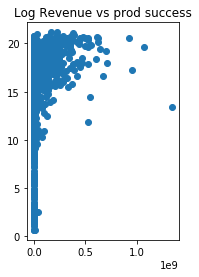

In [368]:
trainpre['log_revenue'] = np.log1p(trainpre['revenue'])
plt.subplot(1, 2, 1)
plt.scatter(trainpre['producer_success'], trainpre['log_revenue'])
plt.title('Log Revenue vs prod success');

In [380]:
trainpre.iloc[470]

id                                                                     471
belongs_to_collection                                                    0
budget                                                             2000000
genres                                                                 NaN
original_language                                                       en
original_title             The Book of Mormon Movie, Volume 1: The Journey
production_companies                                                     0
production_countries                                                   NaN
release_date                                                     9/12/2003
runtime                                                                120
spoken_languages                                                       NaN
title                      The Book of Mormon Movie, Volume 1: The Journey
Keywords                                                               NaN
cast                     

In [359]:
workerResults

,Director,Producer,actor1,actor2,revenue,date
0,Steve Pink,Andrew Panay,Rob Corddry,Craig Robinson,12314651.0,2015
1,Garry Marshall,Whitney Houston,Anne Hathaway,Julie Andrews,95149435.0,2004
2,Damien Chazelle,Jason Blum,Miles Teller,J.K. Simmons,13092000.0,2014
3,Sujoy Ghosh,Sujoy Ghosh,Vidya Balan,Nawazuddin Siddiqui,16000000.0,2012
4,Jong-seok Yoon,None,Kim Kang-woo,Jo Jae-hyeon,3923970.0,2009
...,...,...,...,...,...,...
4393,Michael Cristofer,Kate Guinzburg,Angelina Jolie,Antonio Banderas,35402320.0,2004
4394,Steven Brill,Donald De Line,Seth Green,Matthew Lillard,69631118.0,1982
4395,Sidney Lumet,Richard D. Zanuck,Paul Newman,Charlotte Rampling,53977250.0,2015
4396,David Robert Mitchell,Rebecca Green,Maika Monroe,Keir Gilchrist,14674076.0,1962


In [238]:
def Sort(sub_li): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    return(sorted(sub_li, key = lambda x: x[0]))   

for key in directorsAndMovies:
    directorsAndMovies[key] = Sort(directorsAndMovies[key])
    
directorsAndMovies

{'Steve Pink': [[2006, 38505009.0],
  [2010, 64572262.0],
  [2014, 49002684.0],
  [2015, 12314651.0]],
 'Garry Marshall': [[1982, 30688860.0],
  [1988, 57041866.0],
  [1994, 6841570.0],
  [1999, 309457509.0],
  [2001, 165335153.0],
  [2004, 95149435.0],
  [2005, 0.0],
  [2006, 26713187.0],
  [2006, 463000000.0],
  [2011, 0.0],
  [2012, 0.0],
  [2016, 48418160.0],
  [2016, 0.0]],
 'Damien Chazelle': [[2009, 445435700.0], [2014, 13092000.0]],
 'Sujoy Ghosh': [[2012, 16000000.0]],
 'Jong-seok Yoon': [[2009, 3923970.0]],
 'Hal Sutherland': [[1987, 3261638.0]],
 'Ole Bornedal': [[1997, 1179002.0], [2012, 85446075.0]],
 'Jehane Noujaim': [[2004, 2586511.0]],
 'Brian Henson': [[1996, 34327391.0], [2002, 0.0]],
 'Christopher Guest': [[2003, 18750246.0], [2007, 0.0], [2017, 5542025.0]],
 'John G. Avildsen': [[1976, 117235147.0],
  [1980, 38956288.0],
  [1981, 0.0],
  [1986, 115103979.0],
  [1987, 41232.0],
  [1988, 17514553.0],
  [1990, 119946358.0],
  [2004, 29916207.0],
  [2010, 19319254.0],


In [322]:
testD = 'Ken Kwapis'
testDate = 2007
print(getDirectorSuccess(testD, directorsAndMovies, testDate))
meme = directorsAndMovies[testD]
av = meme[0][1] + meme[1][1] + meme[2][1]
print(av/3)


NameError: name 'director' is not defined

In [302]:
test['directorSuccess'] = test.apply(lambda row: getDirectorSuccess(row.rel_crew['Director'], int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)

In [335]:
combined['directorSuccess'] = combined.apply(lambda row: getDirectorSuccess(row.rel_crew['Director'], int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)
train['directorSuccess'] = train.apply(lambda row: getDirectorSuccess(row.rel_crew['Director'], int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)
test['directorSuccess'] = test.apply(lambda row: getDirectorSuccess(row.rel_crew['Director'], int(row.release_date[-4:])) if row.release_date != 'nan' and 'Director' in row.rel_crew.keys() and type(row.release_date) == str else 0, axis = 1)

TypeError: ("getDirectorSuccess() missing 1 required positional argument: 'date'", 'occurred at index 0')

In [305]:
type(int(combined.iloc[4397]['release_date'][-4:]))
getDirectorSuccess(combined.iloc[4397]['rel_crew']['Director'], 2005)

35235789.5

In [310]:
combined['log_revenue'] = np.log1p(combined['revenue'])

In [211]:
result

,Director,revenue,date
0,Steve Pink,12314651.0,2015
1,Garry Marshall,95149435.0,2004
2,Damien Chazelle,13092000.0,2014
3,Sujoy Ghosh,16000000.0,2012
4,Jong-seok Yoon,3923970.0,2009
...,...,...,...
4393,Michael Cristofer,35402320.0,2004
4394,Steven Brill,69631118.0,1982
4395,Sidney Lumet,53977250.0,2015
4396,David Robert Mitchell,14674076.0,1962


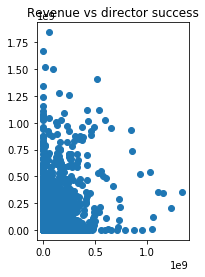

In [333]:

#plt.subplot(1, 2, 1)
#plt.scatter(combined['directorSucess'], combined['log_revenue'])
#plt.title('Log Revenue vs director success');
plt.subplot(1, 2, 2)
plt.scatter(combined['directorSucess'], combined['revenue'])
plt.title('Revenue vs director success');

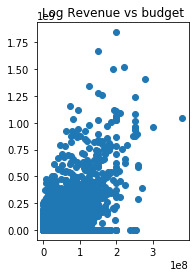

In [334]:
plt.subplot(1, 2, 2)
plt.scatter(combined['budget'], combined['log_revenue'])
plt.title('Log Revenue vs budget ');